##Feature Extraction And Analysis Exercise

In today's exercise, you will pre-process a few cat images, extract HOG features from them, and compare those HOG feature vectors using three different distance metrics.

##TO DO's

**1) Pre-process the images to be all the same size**

Start by calculating the ratio of the short side of the image relative to the desired output size (M). Use this ratio to rescale the image so that the shortest side is equal to M.

Next, center-crop the image to size M on the other dimension. The result should be a square image size MxM.

**2) Compute three kinds of distance functions using the HOG features**

For each pair of images, fill in the corresponding distance matrix with the pairwise distance calculation. Use the built in functions provided (mean_squared_error, wasserstein_distance, cosine).

**3) Display the closest and furthest pairs for each distance calculation**

Use nanargmin and nanargmax to get the smallest and largest distance values for each distance metric. Then calculate the corresponding row and column for each index, and display those image pairs.

**Extra Credit**

Try playing around with various image transformations to see how they might impact the computed distance values. Also experiment with different parameters for your HOG feature vector. Try swapping in other images or feature vectors as well. Note that HOG + RMSE/Cosine is very sensitive to image alignment.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib

from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine

In [ ]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):
    img = np.array(Image.open(urllib.request.urlopen(in_path)))

    # convert to floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0

    # convert to grayscale
    if len(img.shape) > 2:
        img = rgb2gray(img)

    return img

def rescale_image(img):
  # rescale short side to standard size, then crop center
  standard = 256
  scale = standard / min(img.shape[:2])
  img = rescale(img, scale, anti_aliasing=True)
  img = img[int(img.shape[0]/2 - standard/2) : int(img.shape[0]/2 + standard/2),
            int(img.shape[1]/2 - standard/2) : int(img.shape[1]/2 + standard/2)]
  return img

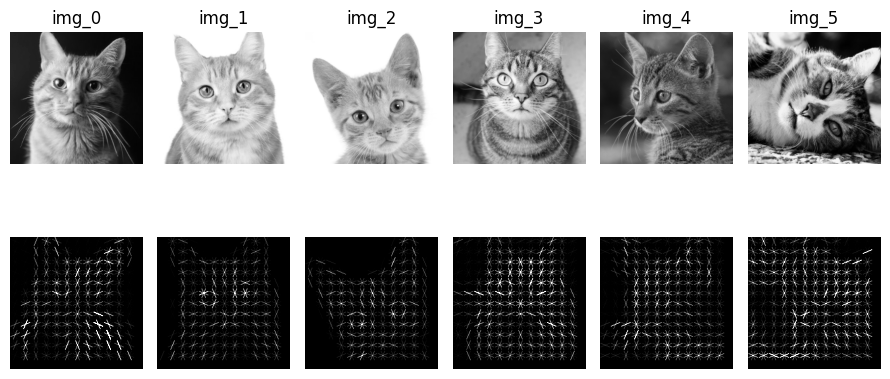

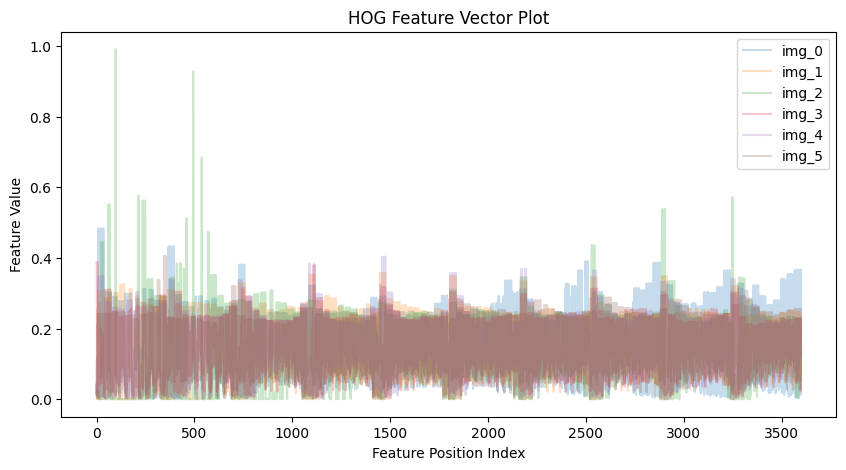

In [ ]:
impaths = ['https://github.com/W281/fileRepository/blob/main/cat_1.jpg?raw=true',
           'https://github.com/W281/fileRepository/blob/main/cat_2.jpg?raw=true',
           'https://github.com/W281/fileRepository/blob/main/cat_3.jpg?raw=true',
           'https://github.com/W281/fileRepository/blob/main/cat_4.jpg?raw=true',
           'https://github.com/W281/fileRepository/blob/main/cat_5.jpg?raw=true',
           'https://github.com/W281/fileRepository/blob/main/cat_6.jpg?raw=true']

fig, ax = plt.subplots(nrows=2, ncols=len(impaths), figsize=(9,5))
images = []
features = []

for i, impath in enumerate(impaths):
  im_processed = rescale_image(read_image(impath))
  #if i == 3:
    # im_processed = rotate(im_processed, -90)
    # im_processed = im_processed[:, ::-1]
    # im_processed = rescale_intensity(im_processed, (0,1))
  images.append(im_processed)
  f, h = hog(im_processed, orientations=4, pixels_per_cell=(20, 20), visualize=True)
  features.append(f)
  ax[0,i].imshow(im_processed, cmap='gray', vmin=0, vmax=1)
  ax[0,i].axis('off')
  ax[0,i].set_title('img_{}'.format(i))
  ax[1,i].imshow(10*h, cmap='gray', vmin=0, vmax=0.5)
  ax[1,i].axis('off')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for f in features:
  plt.plot(f, alpha=0.25)
plt.title("HOG Feature Vector Plot")
plt.xlabel("Feature Position Index")
plt.ylabel("Feature Value")
plt.legend(['img_{}'.format(i) for i in range(len(impaths))])
plt.show()

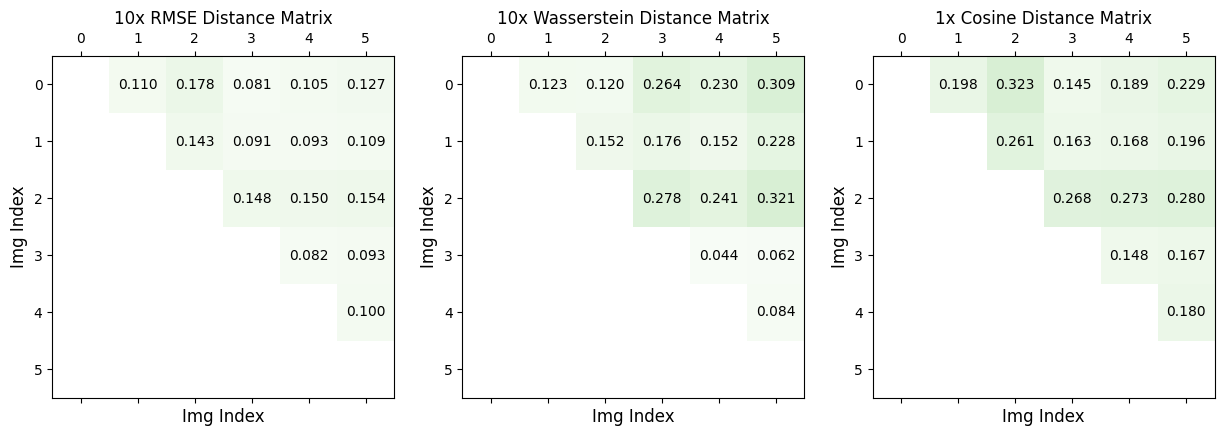

In [ ]:
# compute distances
N = len(features)
features = np.array(features)
dist_rmse = np.nan * np.ones((N, N))
dist_wass = np.nan * np.ones((N, N))
dist_cosn = np.nan * np.ones((N, N))
for i in range(N):
  for j in range(i+1, N):
    dist_rmse[i, j] = mean_squared_error(features[i], features[j])
    dist_wass[i, j] = wasserstein_distance(features[i], features[j])
    dist_cosn[i, j] = cosine(features[i], features[j])

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
for fi, (label, distval) in enumerate(zip(['RMSE', 'Wasserstein', 'Cosine'], [dist_rmse, dist_wass, dist_cosn])):
  if label == 'Cosine': sf=1
  else: sf=10

  ax[fi].matshow(sf*distval, cmap=plt.cm.Greens, alpha=0.5, vmin=0, vmax=1)
  for i in range(distval.shape[0]):
      for j in range(distval.shape[1]):
          ax[fi].text(x=j, y=i, s=['{:.3f}'.format(sf*distval[i, j]) if not np.isnan(distval[i,j]) else ''][0], va='center', ha='center', size='medium')
  ax[fi].set_xlabel('Img Index', fontsize=12)
  ax[fi].set_ylabel('Img Index', fontsize=12)
  ax[fi].set_title('{}x {} Distance Matrix'.format(sf,label), fontsize=12)

plt.show()


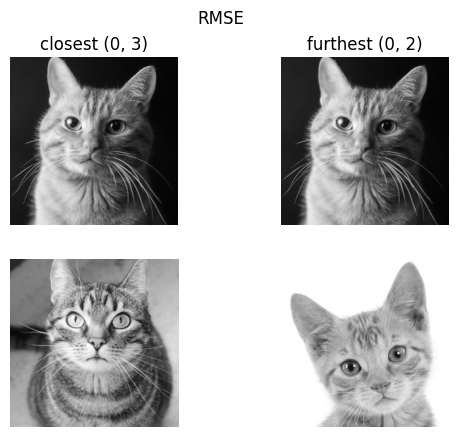

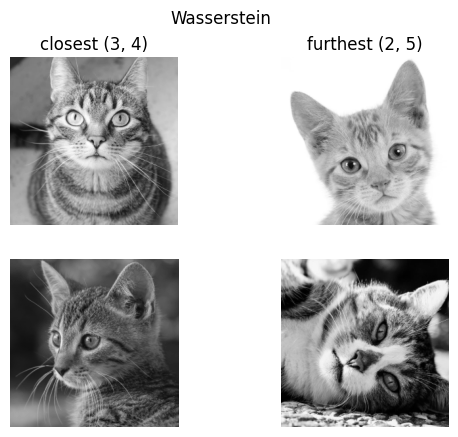

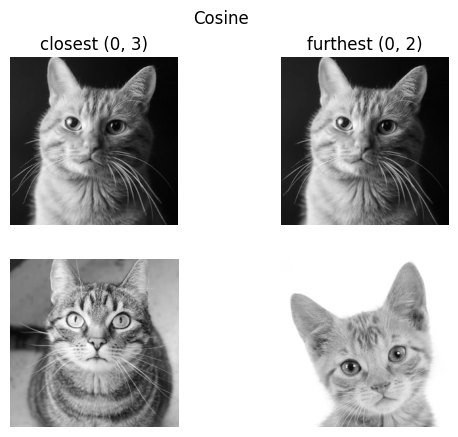

In [ ]:
for label, distval in zip(['RMSE', 'Wasserstein', 'Cosine'], [dist_rmse, dist_wass, dist_cosn]):
  min_ix = np.nanargmin(distval)
  max_ix = np.nanargmax(distval)
  closest_pair = (min_ix // N, min_ix % N)
  furthest_pair = (max_ix // N, max_ix % N)
  #print("{}:\nclosest {}\nfurthest {}\n".format(label, closest_pair, furthest_pair))

  fig, ax = plt.subplots(nrows=2, ncols=2)
  fig.suptitle(label)
  ax[0,0].set_title("closest {}".format(closest_pair))
  ax[0,0].imshow(images[closest_pair[0]], cmap='gray', vmin=0, vmax=1)
  ax[1,0].imshow(images[closest_pair[1]], cmap='gray', vmin=0, vmax=1)
  ax[0,1].set_title("furthest {}".format(furthest_pair))
  ax[0,1].imshow(images[furthest_pair[0]], cmap='gray', vmin=0, vmax=1)
  ax[1,1].imshow(images[furthest_pair[1]], cmap='gray', vmin=0, vmax=1)
  for axrow in range(2):
    for axcol in range(2):
      ax[axrow, axcol].set_axis_off()
  plt.show()